In [5]:
%%bash
curl 'http://real-chart.finance.yahoo.com/table.csv?s=%5EGDAXI&a=10&b=26&c=1990&d=05&e=19&f=2016&g=d&ignore=.csv' > data/table.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  472k    0  472k    0     0   609k      0 --:--:-- --:--:-- --:--:--  609k


In [2]:
def load_snp_returns():
    f = open('data/table.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]

def load_snp_close():
    f = open('data/table.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[4])
            raw_data.append(close_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data, raw_dates

def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y

def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    X_train = X[0:len(X) * percentage]
    Y_train = y[0:len(y) * percentage]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[len(X) * percentage:]
    Y_test = y[len(X) * percentage:]

    return X_train, X_test, Y_train, Y_test

Data loading...


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Building model...
Train on 5224 samples, validate on 581 samples
Epoch 1/5
5224/5224 [==============================] - 0s - loss: 0.5303 - val_loss: 0.3185
Epoch 2/5
5224/5224 [==============================] - 0s - loss: 0.2707 - val_loss: 0.1980
Epoch 3/5
5224/5224 [==============================] - 0s - loss: 0.1650 - val_loss: 0.0848
Epoch 4/5
5224/5224 [==============================] - 0s - loss: 0.0955 - val_loss: 0.0379
Epoch 5/5
128/646 [====>.........................] - ETA: 0s0.0224077910727
2602277.80336


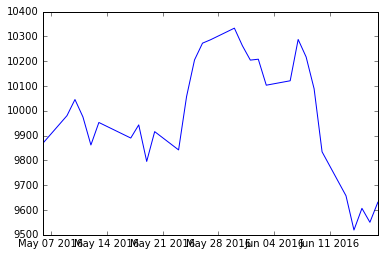

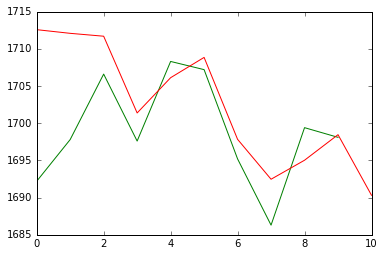

In [43]:
%matplotlib inline

import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback
from processing import *


class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.i = 0
        self.save_every = 5000

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(X_train)
            self.predictions.append(pred)



TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

print 'Data loading...'  
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates[:30], timeseries[:30])

TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)


print 'Building model...'
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print score


params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []
for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print mse

try:
    fig = plt.figure()
    #plt.plot(Y_test[:10], color='black') # BLUE - trained RESULT
    #plt.plot(predicted[:11], color='blue') # RED - trained PREDICTION
    plt.plot(Y_testp[:10], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:11], color='red') # ORANGE - restored PREDICTION
    plt.show()
except Exception as e:
    print str(e)